In [1]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../../../slayerPytorch/src")

In [2]:
import slayerSNN as snn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dtw import dtw, accelerated_dtw
from numpy.linalg import norm
from joblib import Parallel, delayed
import torch
import copy
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

np.random.seed(1)
torch.manual_seed(1)

In [3]:
#X = np.load('auxiliaries/electrodes.npy')
X = torch.load('../BioTac_Icub_data/Bio_all.pt').permute(0,2,1).numpy()
X_i = torch.load('../BioTac_Icub_data/ICUB_all.pt').reshape([1000, 60, 75]).numpy()
#Y = np.load('auxiliaries/labels.npy')
Y = np.load('../BioTac_Icub_data/ICUB_all_labels.npy')

In [4]:
X.shape, Y.shape, X_i.shape

((1000, 19, 150), (1000,), (1000, 60, 75))

In [5]:
def get_ohe(_Y):
    target_class = np.zeros([_Y.shape[0], 20])
    for i in range(target_class.shape[0]):
        target_class[i, int(_Y[i])] = 1
    return target_class

In [6]:
X = X.reshape(X.shape[0], X.shape[1], 1, 1, X.shape[-1])
X_i = X_i.reshape(X_i.shape[0], X_i.shape[1], 1, 1, X_i.shape[-1])
indices = np.arange(X.shape[0])

In [7]:
X_train, X_test, y_train, y_test, ind_train, ind_test = train_test_split(X, Y, indices, test_size=0.30, random_state=42, stratify=Y)

In [8]:
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

target_class_train = torch.FloatTensor(get_ohe(y_train).reshape(-1, 20, 1, 1, 1))
    
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)
target_class_test= torch.FloatTensor(get_ohe(y_test).reshape(-1, 20, 1, 1, 1))

X_train_i= torch.FloatTensor(X_i[ind_train])
X_test_i = torch.FloatTensor(X_i[ind_test])

X_train.shape, y_train.shape, target_class_train.shape, X_train_i.shape

(torch.Size([700, 19, 1, 1, 150]),
 torch.Size([700]),
 torch.Size([700, 20, 1, 1, 1]),
 torch.Size([700, 60, 1, 1, 75]))

In [9]:
params = {
    "neuron": {
        "type": "SRMALPHA",
        "theta": 5, # 10
        "tauSr": 10.0,
        "tauRef": 2.0,
        "scaleRef": 2,
        "tauRho": 1,
        "scaleRho": 1,
    },
    "simulation": {"Ts": 1.0, "tSample": 150, "nSample": 1},
    "training": {
        "error": {
            "type": "NumSpikes",  # "NumSpikes" or "ProbSpikes"
            "probSlidingWin": 20,  # only valid for ProbSpikes
            "tgtSpikeRegion": {  # valid for NumSpikes and ProbSpikes
                "start": 0,
                "stop": 150,
            },
            "tgtSpikeCount": {True: 120, False: 20},
        }
    },
}

params2 = {
    "neuron": {
        "type": "SRMALPHA",
        "theta": 5, # 10
        "tauSr": 10.0,
        "tauRef": 2.0,
        "scaleRef": 2,
        "tauRho": 1,
        "scaleRho": 1,
    },
    "simulation": {"Ts": 1.0, "tSample": 150, "nSample": 1},
    "training": {
        "error": {
            "type": "SpikeTime",  # "NumSpikes" or "ProbSpikes"
            "probSlidingWin": 20,  # only valid for ProbSpikes
            "tgtSpikeRegion": {  # valid for NumSpikes and ProbSpikes
                "start": 0,
                "stop": 150,
            },
            "tgtSpikeCount": {True: 120, False: 20},
        }
    },
}

In [10]:
train_dataset = torch.utils.data.TensorDataset(X_train_i, X_train, target_class_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=8)

test_dataset = torch.utils.data.TensorDataset(X_test_i, X_test, target_class_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset,shuffle=True,batch_size=8)

In [11]:
class SimpleMLP(torch.nn.Module):
    def __init__(self, params, input_size, hidden_size, output_size):
        super(SimpleMLP, self).__init__()
        self.slayer = snn.layer(params["neuron"], params["simulation"])
        self.fc1 = self.slayer.dense(input_size, hidden_size)
        self.fc2 = self.slayer.dense(hidden_size, output_size) # classifier
    
    def forward(self, spike_input):
        spike_1 = self.slayer.spike(self.slayer.psp(self.fc1(spike_input)))
        spike_2 = self.slayer.spike(self.slayer.psp(self.fc2(spike_1)))        
        return spike_2

In [12]:
class AE(torch.nn.Module):
    def __init__(self, params):
        super(AE, self).__init__()
        self.slayer = snn.layer(params["neuron"], params["simulation"])
        
        self.encoder_i = SimpleMLP(params, 60, 50, 40)
        self.encoder_b = SimpleMLP(params, 19, 50, 40)
        
        self.fc_classr_i = self.slayer.dense(40, 20)
        self.fc_classr_b = self.slayer.dense(40, 20)
        
        self.fc = self.slayer.dense(80, 40)
        
        self.decoder_i = SimpleMLP(params, 40, 30, 60)
        self.decoder_b = SimpleMLP(params, 40, 30, 19)
        
    def get_spike(self, inp):
        return self.slayer.spike(inp)
    
    def forward(self, spike_input_i, spike_input_b):

        # encoder
        encoded_i = self.encoder_i(spike_input_i)
        encoded_b = self.encoder_b(spike_input_b)
        
        # classifier
        output_class_i = self.slayer.spike(self.slayer.psp(self.fc_classr_i(encoded_i)))
        output_class_b = self.slayer.spike(self.slayer.psp(self.fc_classr_b(encoded_b)))
        
        # concat
        merged = torch.cat([encoded_i, encoded_b], dim=1)
        
        # representation
        rep = self.slayer.spike(self.slayer.psp(self.fc(merged)))
                        
        # decoder
        decoded_i = self.decoder_i(rep)
        decoded_b = self.decoder_b(rep)
        
        return output_class_i, output_class_b, rep, decoded_i, decoded_b, encoded_i, encoded_b

In [13]:
device = torch.device("cuda:1")
net = AE(params).to(device)

In [14]:
error = snn.loss(params).to(device)
error2 = snn.loss(params2).to(device)
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001, weight_decay=0.5)

In [16]:
train_total_losses=[]
train_class_losses_i=[]
train_class_losses_b=[]
train_regres_losses_i=[]
train_regres_losses_b=[]

test_total_losses=[]
test_class_losses_i=[]
test_class_losses_b=[]
test_regres_losses_i=[]
test_regres_losses_b=[]

train_accs_i = []
train_accs_b = []

test_accs_i = []
test_accs_b = []

alpha1 = alpha2 = 1
beta1 = beta2 = 0.001
gamma = 0.001
for epoch in range(601):
    net.train()
    correct_i = 0
    correct_b = 0
    loss_train = 0
    loss_train = 0
    loss_class_i = 0
    loss_class_b = 0
    loss_reg_i = 0
    loss_reg_b = 0
    for i, (tact_i, tact_b, target, label) in enumerate(train_loader):
        
        # prepare input data
        target = target.to(device)
        tact_i = tact_i.to(device)
        tact_b = tact_b.to(device)
        
        tact_i = net.get_spike(tact_i)
        tact_b = net.get_spike(tact_b)
        
        # impute icub
        tact_new = torch.zeros((tact_i.shape[0],tact_i.shape[1],1,1,tact_i.shape[-1]*2)).to(device)
        tact_new[...,::2]  = tact_i
        tact_i = tact_new
        
        # forward pass
        output_i, output_b, _, out_i, out_b ,enc_i, enc_d = net.forward(tact_i, tact_b)
                
        # loss
        correct_i += torch.sum(snn.predict.getClass(output_i) == label).data.item()
        correct_b += torch.sum(snn.predict.getClass(output_b) == label).data.item()
        
        loss_sim = error2.spikeTime(enc_i, enc_d)
        
        loss_class_i = error.numSpikes(output_i, target)
        loss_class_b = error.numSpikes(output_b, target)
        
        loss_reg_i = error2.spikeTime(out_i, tact_i)
        loss_reg_b = error2.spikeTime(out_b, tact_b)
        
        loss = alpha1*loss_class_i + alpha2*loss_class_b + beta1*loss_reg_i + beta2*loss_reg_b + gamma*loss_sim
        
        loss_train += loss.item()
        loss_class_i = alpha1*loss_class_i.item()
        loss_class_b = alpha2*loss_class_b.item()
        loss_reg_i = beta1*loss_reg_i.item()
        loss_reg_b = beta2*loss_reg_b.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
    if epoch%10 == 0:
        print('Epoch: ', epoch, ' --------------------------')
        print('Train loss (all, class_i, class_b, icub_reg, bio_reg):', 
              loss_train/len(train_dataset),
              loss_class_i/len(train_dataset),
              loss_class_b/len(train_dataset),
              loss_reg_i/len(train_dataset),
              loss_reg_b/len(train_dataset))
        print('Train accuracy(i,b):', correct_i/len(train_dataset), 
                  correct_b/len(train_dataset))
    train_accs_i.append(correct_i/len(train_dataset))
    train_accs_b.append(correct_b/len(train_dataset))
    train_total_losses.append(loss_train/len(train_dataset))
    train_class_losses_i.append(loss_class_i/len(train_dataset))
    train_class_losses_b.append(loss_class_b/len(train_dataset))
    train_regres_losses_i.append(loss_reg_i/len(train_dataset))
    train_regres_losses_b.append(loss_reg_b/len(train_dataset))
        
    net.eval()
    correct_i = 0
    correct_b = 0
    loss_test = 0
    loss_class_i = 0
    loss_class_b = 0
    loss_reg_i = 0
    loss_reg_b = 0
    with torch.no_grad():
        for i, (tact_i,tact_b, target, label) in enumerate(test_loader):

            # prepare input data
            target = target.to(device)
            tact_i = tact_i.to(device)
            tact_b = tact_b.to(device)

            tact_i = net.get_spike(tact_i)
            tact_b = net.get_spike(tact_b)

            # impute icub
            tact_new = torch.zeros((tact_i.shape[0],tact_i.shape[1],1,1,tact_i.shape[-1]*2)).to(device)
            tact_new[...,::2]  = tact_i
            tact_i = tact_new

            # forward pass
            output_i, output_b, _, out_i, out_b ,enc_i, enc_d  = net.forward(tact_i, tact_b)

            # loss
            correct_i += torch.sum(snn.predict.getClass(output_i) == label).data.item()
            correct_b += torch.sum(snn.predict.getClass(output_b) == label).data.item()
            loss_class_i = error.numSpikes(output_i, target)
            loss_class_b = error.numSpikes(output_b, target)

            loss_reg_i = error2.spikeTime(out_i, tact_i)
            loss_reg_b = error2.spikeTime(out_b, tact_b)

            loss = alpha1*loss_class_i + alpha2*loss_class_b + beta1*loss_reg_i + beta2*loss_reg_b

            loss_test += loss.item()
            loss_class_i = alpha1*loss_class_i.item()
            loss_class_b = alpha2*loss_class_b.item()
            loss_reg_i = beta1*loss_reg_i.item()
            loss_reg_b = beta2*loss_reg_b.item()

            loss_test += loss.item()
    
    if epoch%10 == 0:
        print('Test loss (all, class_i, class_b, icub_reg, bio_reg):', 
              loss_test/len(test_dataset),
              loss_class_i/len(test_dataset),
              loss_class_b/len(test_dataset),
              loss_reg_i/len(test_dataset),
              loss_reg_b/len(test_dataset))
        print('Test accuracy(i,b):', correct_i/len(test_dataset), 
                  correct_b/len(test_dataset))
    test_accs_i.append(correct_i/len(test_dataset))
    test_accs_b.append(correct_b/len(test_dataset))
    test_total_losses.append(loss_test/len(test_dataset))
    test_class_losses_i.append(loss_class_i/len(test_dataset))
    test_class_losses_b.append(loss_class_b/len(test_dataset))
    test_regres_losses_i.append(loss_reg_i/len(test_dataset))
    test_regres_losses_b.append(loss_reg_b/len(test_dataset))

Epoch:  0  --------------------------
Train loss (all, class_i, class_b, icub_reg, bio_reg): 593.8391195242746 0.35837145124162945 0.3263142830984933 0.10605505580357143 0.27018375
Train accuracy(i,b): 0.04285714285714286 0.03571428571428571
Test loss (all, class_i, class_b, icub_reg, bio_reg): 355.34399251302085 0.7591444905598959 0.7795000203450521 0.13735908854166667 0.71580984375
Test accuracy(i,b): 0.06666666666666667 0.06333333333333334
Epoch:  10  --------------------------
Train loss (all, class_i, class_b, icub_reg, bio_reg): 404.23412946428573 0.15411904471261162 0.16864761352539062 0.059969017857142856 0.07389877232142857
Train accuracy(i,b): 0.49142857142857144 0.40714285714285714
Test loss (all, class_i, class_b, icub_reg, bio_reg): 165.97546936035155 0.5031333414713541 0.339522221883138 0.11712539062499999 0.2192125
Test accuracy(i,b): 0.5266666666666666 0.4266666666666667
Epoch:  20  --------------------------
Train loss (all, class_i, class_b, icub_reg, bio_reg): 364.65

Test loss (all, class_i, class_b, icub_reg, bio_reg): 64.49157368977865 0.2871111043294271 0.17764444986979167 0.03648612630208334 0.07516000651041667
Test accuracy(i,b): 0.76 0.8966666666666666
Epoch:  190  --------------------------
Train loss (all, class_i, class_b, icub_reg, bio_reg): 191.1048819405692 0.027980951581682477 0.046628570556640624 0.017517564174107145 0.030761757812500002
Train accuracy(i,b): 0.8514285714285714 0.9271428571428572
Test loss (all, class_i, class_b, icub_reg, bio_reg): 64.27765970865886 0.16686667124430338 0.12174443562825521 0.034906067708333335 0.05018543619791667
Test accuracy(i,b): 0.7733333333333333 0.8966666666666666
Epoch:  200  --------------------------
Train loss (all, class_i, class_b, icub_reg, bio_reg): 185.7561972481864 0.03565237862723214 0.08914285387311663 0.018566473214285714 0.022872505580357142
Train accuracy(i,b): 0.8657142857142858 0.93
Test loss (all, class_i, class_b, icub_reg, bio_reg): 62.94909301757812 0.11306666056315104 0.1273

Epoch:  370  --------------------------
Train loss (all, class_i, class_b, icub_reg, bio_reg): 145.7658820452009 0.0814857155936105 0.029642857142857144 0.01272224609375 0.04048986607142858
Train accuracy(i,b): 0.8957142857142857 0.9557142857142857
Test loss (all, class_i, class_b, icub_reg, bio_reg): 53.071419372558594 0.101266663869222 0.13182223002115886 0.027702493489583334 0.07048864583333334
Test accuracy(i,b): 0.8233333333333334 0.9333333333333333
Epoch:  380  --------------------------
Train loss (all, class_i, class_b, icub_reg, bio_reg): 145.00174891880582 0.02202857153756278 0.03113809585571289 0.015970160435267857 0.028885440848214285
Train accuracy(i,b): 0.89 0.9571428571428572
Test loss (all, class_i, class_b, icub_reg, bio_reg): 53.03304911295573 0.1262555694580078 0.1399000040690104 0.029346263020833336 0.055173450520833334
Test accuracy(i,b): 0.8066666666666666 0.9266666666666666
Epoch:  390  --------------------------
Train loss (all, class_i, class_b, icub_reg, bio_r

Test loss (all, class_i, class_b, icub_reg, bio_reg): 49.22127446492513 0.08931111653645833 0.20053333282470703 0.031237998046875 0.047548209635416665
Test accuracy(i,b): 0.8433333333333334 0.93
Epoch:  560  --------------------------
Train loss (all, class_i, class_b, icub_reg, bio_reg): 136.97865740094866 0.012728571210588728 0.027047620500837054 0.01984218470982143 0.020877283761160714
Train accuracy(i,b): 0.9142857142857143 0.9757142857142858
Test loss (all, class_i, class_b, icub_reg, bio_reg): 48.71408332824707 0.06854443868001302 0.04661110877990723 0.028123167317708333 0.049470644531249997
Test accuracy(i,b): 0.8366666666666667 0.9333333333333333
Epoch:  570  --------------------------
Train loss (all, class_i, class_b, icub_reg, bio_reg): 137.09700945172992 0.047166671752929684 0.01917619024004255 0.020139972098214286 0.02034607142857143
Train accuracy(i,b): 0.9057142857142857 0.9714285714285714
Test loss (all, class_i, class_b, icub_reg, bio_reg): 49.32376490275065 0.14163332

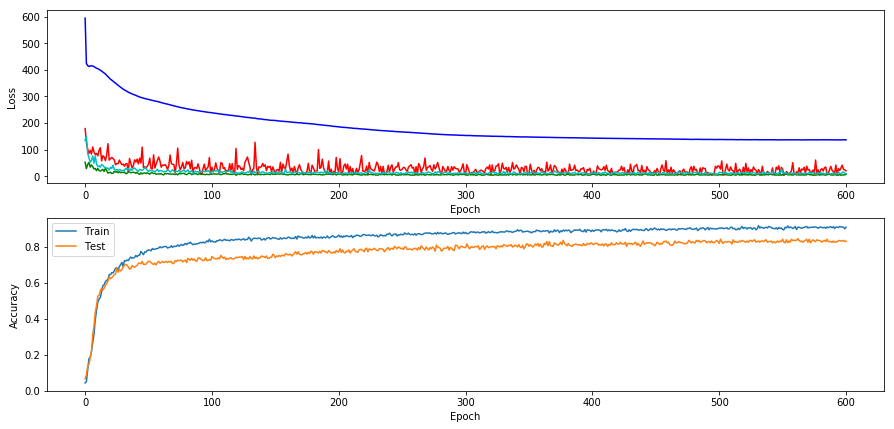

In [17]:
fig, ax = plt.subplots(2, figsize=(15,7))

ax[0].plot(train_total_losses, 'b')
ax[0].plot(500*np.array(train_class_losses_i), 'r')
ax[0].plot(500*np.array(train_regres_losses_i), 'g')
ax[0].plot(500*np.array(train_regres_losses_b), 'c')

# ax[0].plot(test_losses)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(train_accs_i)
ax[1].plot(test_accs_i)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend(['Train', 'Test'])

plt.show()

In [18]:
np.max(test_accs_i), np.max(test_accs_b)

(0.8466666666666667, 0.9433333333333334)

In [19]:
np.max(train_accs_i), np.max(train_accs_b)

(0.9185714285714286, 0.9785714285714285)

In [21]:
net.eval()
big_list = []
label_list=[]

with torch.no_grad():
    for i, (tact_i,tact_b, target, label) in enumerate(test_loader):

        # prepare input data
        target = target.to(device)
        tact_i = tact_i.to(device)
        tact_b = tact_b.to(device)

        tact_i = net.get_spike(tact_i)
        tact_b = net.get_spike(tact_b)

        # impute icub
        tact_new = torch.zeros((tact_i.shape[0],tact_i.shape[1],1,1,tact_i.shape[-1]*2)).to(device)
        tact_new[...,::2]  = tact_i
        tact_i = tact_new

        # forward pass
        _, _, rep, _, _, _, _ = net.forward(tact_i, tact_b)

        big_list.append(rep)
        label_list.append(label)

In [22]:
test_representation = torch.cat(big_list,0)
test_representation.shape

torch.Size([300, 40, 1, 1, 150])

In [23]:
label_all = torch.cat(label_list, 0)

In [24]:
label_all = label_all.cpu().numpy()

In [25]:
%%time
dist_mat = torch.zeros([300,300])
for i in range(300):
    for j in range(300):
        if i == j:
            dist_mat[i, j] = 0.0
        else:
            dist_mat[i,j] = error2.spikeTime(test_representation[i], test_representation[j])

CPU times: user 12.2 s, sys: 136 ms, total: 12.3 s
Wall time: 12.3 s


In [26]:
dist_mat = dist_mat.detach().cpu().numpy()

In [27]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2,perplexity=20, metric='precomputed').fit_transform(dist_mat)

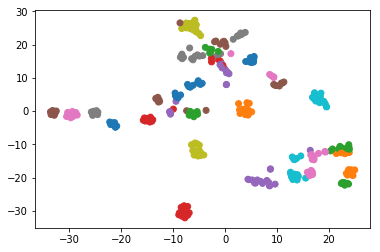

In [28]:
fig, ax = plt.subplots()
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=label_all, cmap=plt.cm.tab10)
plt.show()